# Training Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist = False
cifar10 = True
cifar100 = False
assert mnist ^ cifar10 ^ cifar100

n_classes = 10
if mnist:
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
if cifar10:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
if cifar100:
    n_classes = 100
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    if len(x_grey.size()) == 3:
        helper = torch.unsqueeze(x_grey, 1)
        return helper.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 1:
        return x_grey.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 3:
        return x_grey
    elif len(x_grey.size()) == 4:
        raise ValueError(f'The size of this image tensor is not valid.\
        A 4th order image tensor must have dim1==1 (grey-scale) or dim1==3 (rgb).\
        Unknown format cannot be transformed to rgb.')
    else:
        raise ValueError(f'The size of this image-tensor is not valid.\
        Must be either 3rd (grey-scale) order tensor or 4th order tensor (rgb).\
        Got order {len(x_grey.size())}')
        
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

if mnist:
    X_train_grey = trainset.train_data
    X_train = to_rgb(X_train_grey)
    X_test_grey = testset.test_data
    X_test = to_rgb(X_test_grey)
    y_train = trainset.train_labels
    y_test = testset.test_labels
else:
    X_train = torch.tensor(swap_data(trainset.data))
    y_train = torch.tensor(trainset.targets)
    X_test = torch.tensor(swap_data(testset.data))
    y_test = torch.tensor(testset.targets)
    
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


## Model load, modifications and GPU optimization

In [4]:
from torchvision import models

'''
model = models.resnet18(pretrained=False) # set model here
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
'''

# redefining stuff for AdaSecant test runs
X_train = torch.rand(256, 10)
X_test = torch.rand(256, 10)
y_train = torch.randint(10, (256,))
y_test = torch.randint(10, (256,))

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

model = torch.nn.Sequential(nn.Linear(10, 10), nn.Linear(10, 10))
for param in model.parameters():
    print(param.requires_grad)
    print(param.grad)

dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

X_train: torch.Size([256, 10])
y_train: torch.Size([256])
X_test: torch.Size([256, 10])
y_test: torch.Size([256])
True
None
True
None
True
None
True
None


Check specs for GPU-based training.

In [5]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


## Implementing AdaSecant
https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

<ins>Indices:

- $i\in\{1, ..., n\}$: parameter

- $k\in\{1, ..., m\}$: sample in minibatch

- $j\in\{1, ..., n_{iter}\}$: iteration, $n_{iter} = \lfloor\frac{epochs}{m}\rfloor$ if drop_last else $n_{iter} = \lceil\frac{epochs}{m}\rceil$



<ins>Gradients $g, g'$:

$g^{(j)} = \frac{1}{m}\sum_{k=1}^m\nabla_{\theta_i}f(\theta^{(k)})$ is the current gradient. $g'^{(j)} = \frac{1}{m}\sum_{k=m+1}^{2m}\nabla_{\theta_i}f(\theta^{(k)})$ is the gradient calculated on the consecutive minibatch with the current parameters.
    
Second test run: apply normalization $\hat{g} = \frac{g}{||E[g]||_2}$.


<ins>Moving averages $E[x]_j$:

$$
\begin{aligned}
    E[x]_j &= \left(1 - \frac{1}{\tau^{(j)}}\right)E[x]_{j-1} + \frac{1}{\tau^{(j)}}x^{(j)}
\end{aligned}
$$


<ins>Elements of the Hessian diagnonal $\alpha_i$:

$$
\begin{aligned}
    \alpha_i &= \nabla_{\theta_i}f(\theta + \Delta) - \nabla_{\theta_i}f(\theta)
\end{aligned}
$$

"The Equation 13 can be easily computed in a stochastic setting from the consecutive minibatches":

$$
\begin{aligned}
    \alpha_i^{(j)} &= \nabla_{\theta_i}f(\theta^{(j-1)} + \Delta^{(j-1)}) - \nabla_{\theta_i}f(\theta^{(j-1)}) \\
    &= \nabla_{\theta_i}f(\theta^{(j)}) - \nabla_{\theta_i}f(\theta^{(j-1)}) \\
    &= g^{(j)} - g^{(j-1)}
\end{aligned}
$$


<ins>Correction term $\gamma$:

$$
\begin{aligned}
    \gamma_i &= \frac{E[(g_i - g_i')(g_i - E[g_i]_j)]_j}{E[(g_i - E[g_i]_j)(g_i' - E[g_i]_j)]_j}
\end{aligned}
$$


<ins>Corrected gradient $\tilde{g}$:

$$
\begin{aligned}
    \tilde{g}_i &= \frac{g_i + \gamma_i E[g_i]_j}{1+\gamma_i}
\end{aligned}
$$


<ins>Estimated learning rate $\eta^{(j)}$:

$$
\begin{aligned}
    \eta_i^{(j)} &= \frac{\sqrt{E[\Delta_i^2]_j}}{\sqrt{E[\alpha_i^2]_j}} - \frac{E[\alpha_i\Delta_i]_j}{E[\alpha_i^2]_j}
\end{aligned}
$$


<ins>Update memory size:
    
$$
\begin{aligned}
    \tau_i^{(j+1)} &= (1 - \frac{E^2[\Delta_i]_{j}}{E[\Delta_i^2]_{j}})\tau_i^{(j)} + 1
\end{aligned}
$$


<ins>Update parameters:

$$
\begin{aligned}
    \theta^{(j+1)} &= \theta^{(j)} - \eta^{(j)}\cdot\tilde{g}^{(j)}\\
    &= \theta^{(j)} + \Delta^{(j)}
\end{aligned}
$$

$$
\begin{aligned}
    \Delta^{(j)} &= -\eta^{(j)}\cdot\tilde{g}^{(j)}
\end{aligned}
$$

In [7]:
from typing import List
import copy

class AdaSecant(optim.Optimizer):
    r"""Documentation
    Basis copied from https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py.
    Left out closure, momentum-related stuff, __setstate__ as it does not seem to be necessary.
    """

    def __init__(self, params, lr=None):
        if lr is not None:
            print('Warning: lr is not a parameter for AdaSecant. Your lr will be set to None')
            lr = None
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        print(len(self.param_groups))
        self.ready = False
        self.current_gradients = None
        self.gamma_numerators = []
        self.gamma_denomenators = []
        self.mean_gradients = []
        self.mean_gradient_squares = []
        self.mean_deltas = []
        self.mean_delta_squares = []
        self.mean_alphas = []
        self.mean_alpha_squares = []
        self.mean_delta_times_alphas = []
        self.old_gradients = []
        self.old_deltas = []
        self.taus = []
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    print('hi')
                    self.gamma_numerators.append(torch.zeros_like(p))
                    self.gamma_denomenators.append(torch.zeros_like(p))
                    self.mean_gradients.append(torch.zeros_like(p))
                    self.mean_gradient_squares.append(torch.zeros_like(p))
                    self.mean_deltas.append(torch.zeros_like(p))
                    self.mean_delta_squares.append(torch.zeros_like(p))
                    self.mean_alphas.append(torch.zeros_like(p))
                    self.mean_alpha_squares.append(torch.zeros_like(p))
                    self.mean_delta_times_alphas.append(torch.zeros_like(p))
                    self.taus.append(torch.ones_like(p))
                    self.old_gradients.append(None)
                    self.old_deltas.append(None)
                    
        
        
    @torch.no_grad()
    def pre_step(self):
        for group in self.param_groups:
            d_p_list = []
        
            for p in group['params']:
                # subgrouping of parameters for each layer, bias and weights separately (each tensor)
                if p.grad is not None:
                    d_p_list.append(copy.deepcopy(p.grad))
        
        self.current_gradients = d_p_list
        self.ready = True
        

    @torch.no_grad()
    def step(self):
        """Performs a single optimization step.
        """
        
        if not self.ready:
            raise RuntimeError('You must perform optimizer.pre_step() before performing ' +
                               'optimizer.step() when using AdaSecant.\n' +
                               'pre_step ensures that the gradient is saved while step will generate the ' +
                               'gradient on the new batch.\n' +
                               'Recommended call sequence:' +
                               ' \n model.zero_grad(), \n loss = ..., \n loss.backwards(), \n ' +
                               'optimizer.pre_step(), \n model.zero_grad(), \n loss = ..., \n ' +
                               'loss.backwards(), \n optimizer.step()')
        else:
            self.ready = False

        for group in self.param_groups:
            params_with_grad = []
            next_gradients = []

            for p in group['params']:
                # subgrouping of parameters for each layer, bias and weights separately (each tensor)
                if p.grad is not None:
                    params_with_grad.append(p)
                    next_gradients.append(p.grad)
            
            #print(group)
            print('enter adasecant')
            adasecant(self, params_with_grad, next_gradients)
            
    
def adasecant(optimizer: AdaSecant, params: List[torch.Tensor], next_gradients: List[torch.Tensor]):
    
    for i, param in enumerate(params):
        
        g = optimizer.current_gradients[i]
        g_next = next_gradients[i]
        print(i)
        
        # TODO later: build in normalization of gradients
        
        optimizer.mean_gradients[i] = moving_average(optimizer.mean_gradients[i], g, optimizer.taus[i])
        optimizer.mean_gradient_squares[i] = moving_average(optimizer.mean_gradient_squares[i], g ** 2, optimizer.taus[i])
        
        if optimizer.old_gradients[i] is None:
            # alpha = g for first iteration ==> lr = 0
            alpha = copy.deepcopy(g)
        else:
            # normal calculation of alpha
            alpha = g - optimizer.old_gradients[i]
        optimizer.mean_alphas[i] = moving_average(optimizer.mean_alphas[i], alpha, optimizer.taus[i])
        optimizer.mean_alpha_squares[i] = moving_average(optimizer.mean_alpha_squares[i], alpha ** 2, optimizer.taus[i])
        
        optimizer.gamma_numerators[i] = moving_average(optimizer.gamma_numerators[i],
                                                       (g - g_next)
                                                       * (g - optimizer.mean_gradients[i]),
                                                       optimizer.taus[i])
        optimizer.gamma_denomenators[i] = moving_average(optimizer.gamma_denomenators[i],
                                                         (g - optimizer.mean_gradients[i])
                                                         * (g_next - optimizer.mean_gradients[i]),
                                                         optimizer.taus[i])
        if torch.is_nonzero(optimizer.gamma_denomenators[i].sum()):
            # normal calculation of variance reduction term gamma
            gamma = optimizer.gamma_numerators[i] / optimizer.gamma_denomenators[i]
        else:
            # gradient is equal to expected gradient in first epoch
            # gamma is therefore zero (equivalent to no variance reduction)
            gamma = torch.zeros_like(optimizer.gamma_denomenators[i])
            
        corrected_gradient = (g + gamma * optimizer.mean_gradients[i]) / (1 + gamma)
        
        optimizer.taus[i] = torch.where(needs_memory_reset(g, alpha, optimizer, i),
                                        torch.full_like(optimizer.taus[i], 2.2),
                                        optimizer.taus[i])
        
        if optimizer.old_deltas[i] is None:
            delta = copy.deepcopy(corrected_gradient)
        else:
            delta = optimizer.old_deltas[i]
        optimizer.mean_deltas[i] = moving_average(optimizer.mean_deltas[i], delta, optimizer.taus[i])
        optimizer.mean_delta_squares[i] = moving_average(optimizer.mean_delta_squares[i], delta ** 2, optimizer.taus[i])
        optimizer.mean_delta_times_alphas[i] = moving_average(optimizer.mean_delta_times_alphas[i],
                                                             delta * alpha,
                                                             optimizer.taus[i])
        
        # should I update moving averages for g, gamma, and alpha as well? -> memory size will be set again later
        
        lr = (torch.sqrt(optimizer.mean_delta_squares[i]) / torch.sqrt(optimizer.mean_alpha_squares[i])
             - optimizer.mean_delta_times_alphas[i] / optimizer.mean_alpha_squares[i])
        print('corrected_gradient', corrected_gradient)
        print('lr', lr)
        
        optimizer.taus[i] = ((1 - optimizer.mean_deltas[i] ** 2 / optimizer.mean_delta_squares[i])
                             * optimizer.taus[i] + 1)
        
        new_delta = -lr * corrected_gradient
        params[i] += new_delta
        print('params', params[i])
        
        optimizer.old_deltas[i] = new_delta
        optimizer.old_gradients[i] = g
        

def moving_average(mean, new_value, tau):
    return (1 - 1 / tau) * mean + (1 / tau) * new_value


def needs_memory_reset(g, alpha, optimizer, i):
    return torch.logical_or(torch.gt(torch.abs(g - optimizer.mean_gradients[i]),
                                     2 * torch.sqrt(torch.abs(optimizer.mean_gradient_squares[i] 
                                                              - optimizer.mean_gradients[i] ** 2))),
                            torch.gt(torch.abs(alpha - optimizer.mean_alphas[i]),
                                     2 * torch.sqrt(torch.abs(optimizer.mean_alpha_squares[i]
                                                              - optimizer.mean_alphas[i] ** 2))))

In [8]:
import itertools
from more_itertools import peekable

def adasecant_dataloader(dataset, batch_size, shuffle=False, drop_last=False):
    data_loader = peekable(iter(data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)))
    return data_loader

data_loader = adasecant_dataloader(dataset_test, 60, True, True)
for batch in data_loader:
    #print('current', batch['y'])
    try:
        peek = data_loader.peek()
        #print('next', peek['y'])
    except StopIteration:
        pass

## Training

In [9]:
def evaluate_model(model, dataset, batch_size=1000):
    
    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    loss = 0.0
    correct = 0
    
    for batch in data_loader:
        yhat = model.forward(batch['X'].float().to(device))
        y = batch['y'].long().to(device)
        batch_loss = f_loss(yhat, y)
        loss += batch_loss.item() * len(batch['X'])
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().item()
    accuracy = correct / len(dataset)
    
    return loss, accuracy

def get_scheduler(optimizer, base_lr, max_lr, epochs_per_cycle, len_dataset, batch_size):
    if epochs_per_cycle is None:
        epochs_per_cycle = epochs
    iterations_per_cycle = epochs_per_cycle * (len_dataset // batch_size)
    return torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=iterations_per_cycle / 2)

In [10]:
def train_model(model, dataset, validation_set, batch_size=64, epochs=1, 
                f_loss=F.cross_entropy, epochs_per_cycle=None):
    
    #prepare_model(model)
    optimizer = AdaSecant(model.parameters())
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []
    
    # evaluate initial state of model
    initial_training_loss, _ = evaluate_model(model, dataset)
    epoch_losses.append(initial_training_loss)
    validation_loss, accuracy = evaluate_model(model, validation_set)
    validation_losses.append(validation_loss)
    validation_accuracy.append(accuracy)

    for epoch in range(epochs):
        # training and epoch loss logging
        # drop last to avoid stochastic outliers in gradient update
        data_loader = adasecant_dataloader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0
        
        for batch in data_loader:
            
            # prepare adasecant with current gradient
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item() * len(batch['X'])
            batch_loss.backward()
            optimizer.pre_step()
            
            # run adasecant with next gradient (addiotionally to current gradient)
            model.zero_grad()
            try:
                next_batch = data_loader.peek()
                yhat = model.forward(next_batch['X'].float().to(device))
                batch_loss = f_loss(yhat, next_batch['y'].long().to(device))
                batch_loss.backward()
                optimizer.step()
            except StopIteration:
                # peek in first
                pass
            #return
            
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataset)}')
        epoch_losses.append(epoch_loss)
        
        # calculate validation loss and accuracy
        validation_loss, accuracy = evaluate_model(model, validation_set)
        validation_losses.append(validation_loss)
        validation_accuracy.append(accuracy)
        
    return (np.array(epoch_losses) / len(dataset), 
            np.array(validation_losses) / len(validation_set), 
            validation_accuracy, 
            lr_history)

In [11]:
base_lr = 0.01
max_lr = 0.1
batch_size = 64
epochs = 1
f_loss = F.cross_entropy
cycle = epochs

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device),
                                                                              dataset_train,
                                                                              dataset_test,
                                                                              batch_size,
                                                                              epochs,
                                                                              f_loss,
                                                                              cycle)

1
hi
hi
hi
hi
enter adasecant
0
corrected_gradient tensor([[-0.0163, -0.0114, -0.0059, -0.0156, -0.0313, -0.0329, -0.0217, -0.0150,
         -0.0235, -0.0143],
        [-0.0234, -0.0236, -0.0077, -0.0068, -0.0367, -0.0355, -0.0261, -0.0192,
         -0.0288, -0.0171],
        [ 0.0032, -0.0100, -0.0155, -0.0111, -0.0084, -0.0097, -0.0045, -0.0147,
         -0.0084, -0.0035],
        [ 0.0191,  0.0199,  0.0182,  0.0183,  0.0114,  0.0138,  0.0139,  0.0164,
          0.0118,  0.0172],
        [-0.0244, -0.0304, -0.0235, -0.0320, -0.0449, -0.0399, -0.0314, -0.0295,
         -0.0348, -0.0350],
        [ 0.0163,  0.0098,  0.0140,  0.0210,  0.0225,  0.0187,  0.0188,  0.0132,
          0.0201,  0.0189],
        [ 0.0096,  0.0139,  0.0112,  0.0065, -0.0020, -0.0059,  0.0054,  0.0118,
          0.0007, -0.0017],
        [-0.0065, -0.0080, -0.0047, -0.0027,  0.0020,  0.0013, -0.0001, -0.0013,
         -0.0005, -0.0087],
        [-0.0077, -0.0049, -0.0110, -0.0152,  0.0027,  0.0037, -0.0055, -0.00

params Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       requires_grad=True)
3
corrected_gradient tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
lr tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
params Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Epoch 1/1 - Loss: 

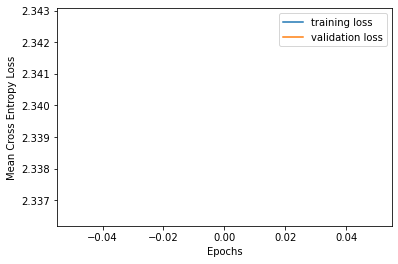

In [12]:
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

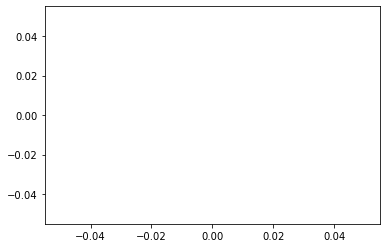

In [13]:
plt.plot(lr_history)

0.11328125


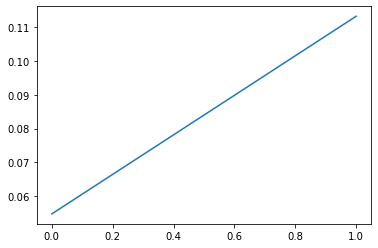

In [14]:
plt.plot(validation_accuracy)
print(max(validation_accuracy))

In [15]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'